In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LinearRegression

from scipy.stats import linregress
import statsmodels.api as sm


------

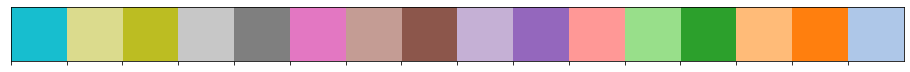

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)

----

# Excercise 2: Moneyball

Moneyball, as well as being a fantastic story, is also a true story of statistical methods being applied in a real world context to make predictions for decision making. [The film Moneyball](https://www.youtube.com/watch?v=-4QPVo0UIzc) is well worth a watch if you have time. As well as in baseball most major competitive sports teams are now using data science to improve their performance, e.g. [football](http://outsideoftheboot.com/2013/06/26/rise-of-data-analysis-in-football/),...

In this excercise you have been hired by Oakland Athletics general manager Billy Beane. Your first mission is to predict the salary each player will make based on other information that is available. This will allow Billy to understand what price he should pay for players in the next transfer season.

You must:
* Import and prepare the data
* Create a train and test set
* Implement a regularised model of your choice (Ridge or Lasso)
* Choose optimal parameters for your regularised model
* Estimate test-error using k-fold cross validation
* Calculate the true test-error
* Run a base line model to compare your model results. Base line model is the most simple approach based on strategy of choice (mean or other). It is then used as reference to conclude whether more complex models are better or not: see DummyRegressor in the sklearn library.

HINT 1
* Some values are missing. You can drop these rows.

HINT 2
* Some columns do not contain numerical values. You can drop these columns. In the Machine Learning model you'll learn more about labeling categorical data

In [3]:
def  compute_indicator(true_values,predicted_values):
    MSE = mean_squared_error(true_values, predicted_values)
    MAE = mean_absolute_error(true_values, predicted_values)
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MEDAE = median_absolute_error(true_values, predicted_values)
    R2 = r2_score(true_values, predicted_values)
    print(f"MSE ----> {MSE}")
    print(f"RMSE ---> {RMSE}")
    print(f"MAE ----> {MAE}")
    print(f"MEDAE --> {MEDAE}")
    print(f"R2 -----> {R2}")
    return MSE, RMSE, MAE, MEDAE, R2

In [4]:
def print_shape(df):
    print(f"Samples ---> {df.shape[0]}")
    print(f"Features --> {df.shape[1]}")

In [5]:
def plot_result_alpha(results, name):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18,9))
    fig.suptitle("Alpha study for" + name, fontsize=20)
    
    sns.lineplot(
        ax=ax[0],
        x=results["param_alpha"], 
        y=-results["mean_test_score"], 
        data=results,
        color=colors[0],
    )
    
    ax[0].set_ylabel("MSE | STD", fontsize=15)
    ax[0].set_title(f"MSE", fontsize=20)
    
    sns.lineplot(
        ax=ax[1],
        x=results["param_alpha"], 
        y=results["std_test_score"], 
        data=results,
        color=colors[0],
    )
    ax[0].set_xlabel(" ", fontsize=15)
    ax[1].set_xlabel("Alpha", fontsize=15)
    ax[1].set_ylabel("STD", fontsize=15)
    
    fig.subplots_adjust(wspace=10)
    plt.show()

# Import and Prepare

In [6]:
df_hitters = pd.read_csv('./data/hitters.csv')
df_hitters = df_hitters.rename(columns={'Unnamed: 0': 'name'})

In [7]:
print_shape(df_hitters)

Samples ---> 322
Features --> 21


In [8]:
df_hitters.dtypes

name          object
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [9]:
df_hitters = df_hitters.drop(df_hitters.select_dtypes(include=['object']).columns, axis=1)
print_shape(df_hitters)

Samples ---> 322
Features --> 17


In [10]:
df_hitters = df_hitters.dropna()
print_shape(df_hitters)
print("---------------------")
print("On perd 59 samples")

Samples ---> 263
Features --> 17
---------------------
On perd 59 samples


In [11]:
salary = df_hitters.pop("Salary")
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25


<AxesSubplot:>

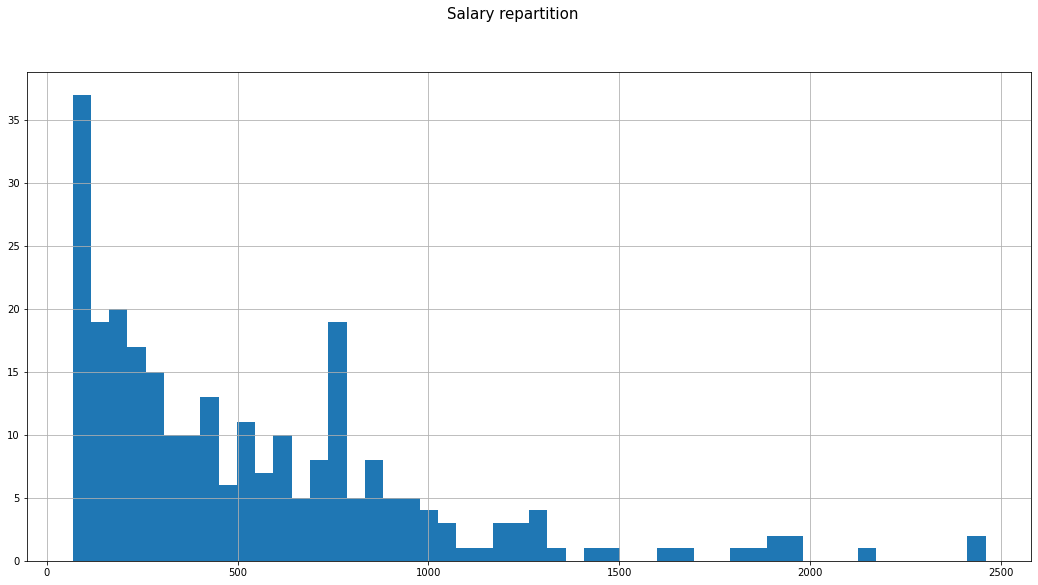

In [24]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Salary repartition", fontsize=15)
salary.hist(bins=50)

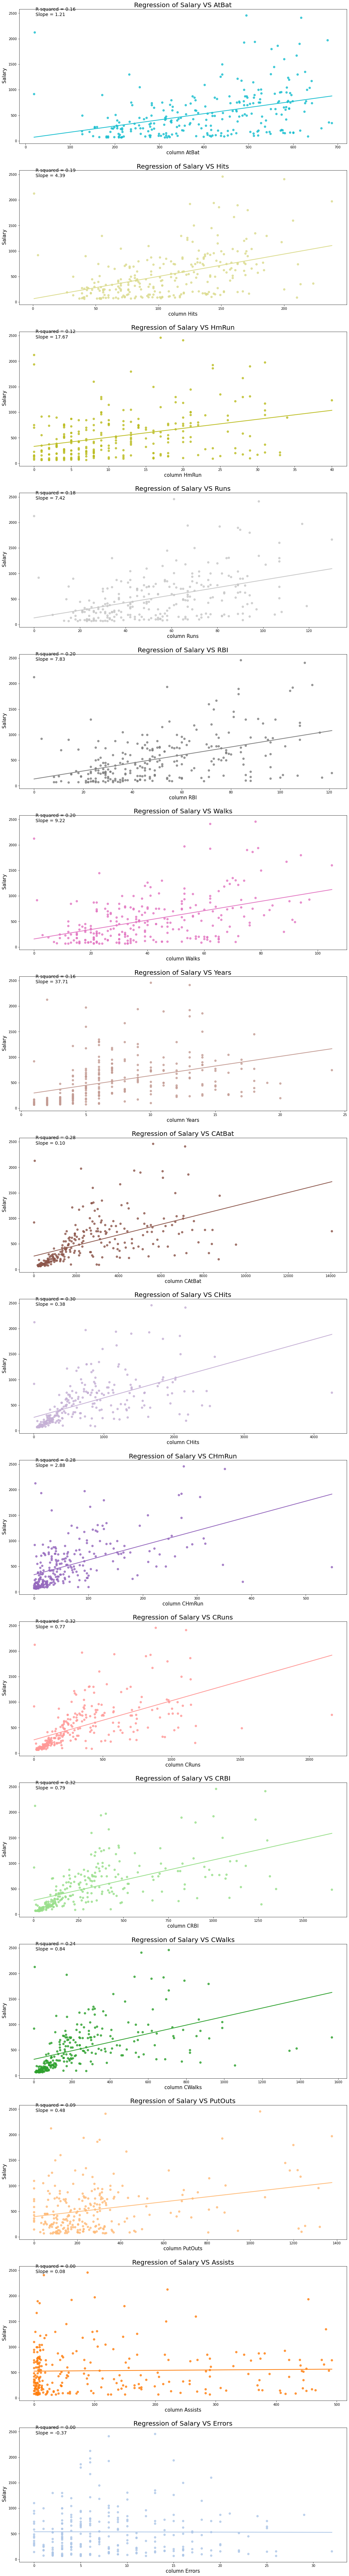

In [25]:
fig, ax = plt.subplots(nrows=len(df_hitters.columns), ncols=1, figsize=(18,9*len(df_hitters.columns)))

for i, col in enumerate(df_hitters.columns):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_hitters[col], salary)
    r_squared = r_value ** 2
    
    sns.regplot(
        ax=ax[i],
        x=col, 
        y=salary, 
        data=df_hitters,
        color=colors[i],
        ci=None
    )
    ax[i].set_xlabel(f"column {col}", fontsize=15)
    ax[i].set_ylabel(f" Salary", fontsize=15)
    ax[i].set_title(f"Regression of Salary VS {col}", fontsize=20)
    ax[i].annotate("R-squared = {:.2f}\nSlope = {:.2f}".format(r_squared, slope),
            xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)

plt.show()

<AxesSubplot:>

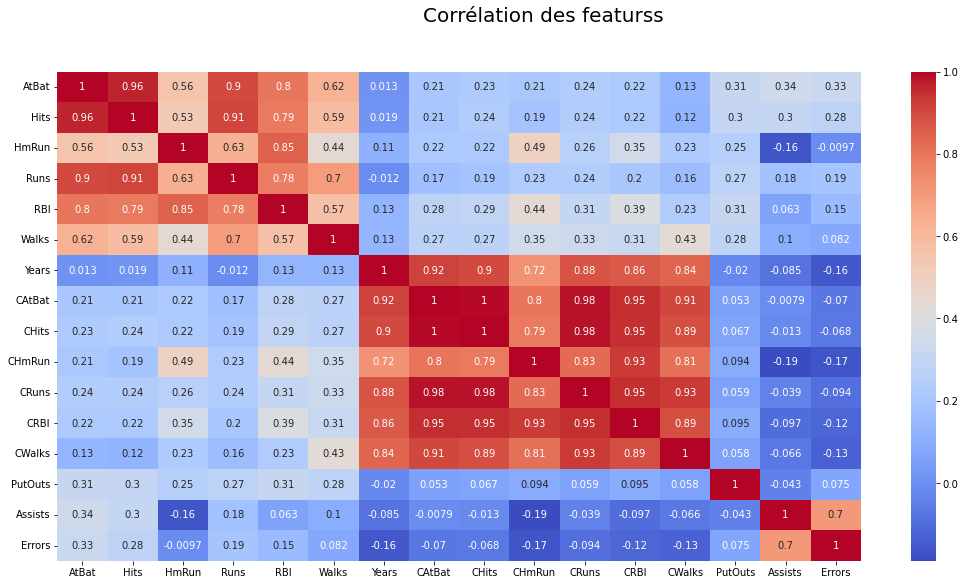

In [28]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Corrélation des featurss", fontsize=20)
sns.heatmap(df_hitters.corr(), cmap="coolwarm", annot=True, annot_kws={"size": 10})

------

In [50]:
print(f"Ecart type de nos données --> {salary.std()}")
print(f"Moyenne de nos données -----> {salary.mean()}")

Ecart type de nos données --> 451.1186807025387
Moyenne de nos données -----> 535.9258821292775


### Prépare test set

In [37]:
def compare_train_test(y_train, y_pred_train, y_test, y_pred_test):
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    print("Results for TRAIN data :")
    print("")
    compute_indicator(y_train, y_pred_train)
    print("----------------------------------------------")
    print("Results for TEST data ")
    print("")
    compute_indicator(y_test, y_pred_test)
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")

In [38]:
def  compute_indicator(true_values,predicted_values):
    MSE = mean_squared_error(true_values, predicted_values)
    MAE = mean_absolute_error(true_values, predicted_values)
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MEDAE = median_absolute_error(true_values, predicted_values)
    R2 = r2_score(true_values, predicted_values)
    print(f"MSE ----> {MSE}")
    print(f"RMSE ---> {RMSE}")
    print(f"MAE ----> {MAE}")
    print(f"MEDAE --> {MEDAE}")
    print(f"R2 -----> {R2}")
    return MSE, RMSE, MAE, MEDAE, R2

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_hitters, salary, random_state = 18)

# Lasso VS Ridge VS Linear

In [51]:
def kfold_study(model, X, y, rangeValue):
    cv_list = []
    MSE_list = []
    RMSE_list = []
    for i in range(rangeValue[0], rangeValue[1], rangeValue[2]):
        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
        print(f"CV ---> {i}")
        crossPrediction = cross_val_predict(model, X, y, cv=i)
        MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y, crossPrediction)
        cv_list.append(i)
        MSE_list.append(MSE)
        RMSE_list.append(RMSE)
        
    return cv_list, MSE_list, RMSE_list

### Linear regression

In [46]:
model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

# predict y values for testing data set
y_pred_train = model_linear.predict(X_train)
y_pred_test = model_linear.predict(X_test)

print("------------------------------------------------------")
print("-------------------- LINEAR MODEL --------------------")
print("------------------------------------------------------")
print("")
MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)
compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

------------------------------------------------------
-------------------- LINEAR MODEL --------------------
------------------------------------------------------

MSE ----> 93902.38051881903
RMSE ---> 306.43495316105674
MAE ----> 240.1304233146088
MEDAE --> 195.92550347718333
R2 -----> 0.4443893225498512
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Results for TRAIN data :

MSE ----> 100601.19453572626
RMSE ---> 317.1769136234954
MAE ----> 215.6727881943707
MEDAE --> 154.57242904158113
R2 -----> 0.5273849576945201
----------------------------------------------
Results for TEST data 

MSE ----> 93902.38051881903
RMSE ---> 306.43495316105674
MAE ----> 240.1304233146088
MEDAE --> 195.92550347718333
R2 -----> 0.4443893225498512
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


In [66]:
cv_scores = cross_val_score(model_linear, X_train, y_train, cv = 10, scoring='neg_mean_squared_error') 
MSE = -cv_scores
RMSE = np.sqrt(MSE)
print("------------------------------------------------------")
print("----------- LINEAR MODEL KFOLD Dispersion ------------")
print("------------------------------------------------------")
print("")
print(f"RMSE --------------------------> {RMSE.mean()}")
print(f"STD des RMSE selon interval ---> {RMSE.std()}")

RMSE --------------------------> 348.9184404965113
STD des RMSE selon interval ---> 108.24828050177739


## Test Lasso on different kfold

In [17]:
cv_list, MSE_list, RMSE_list = kfold_study(lasso, X_train, y_train, [2, 40, 2])

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 2
MSE ----> 161149.92128365842
RMSE ---> 401.4348281896557
MAE ----> 262.951158134894
MEDAE --> 183.6198562034483
R2 -----> 0.24293267871731083
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 4
MSE ----> 150165.39408396246
RMSE ---> 387.51179863839303
MAE ----> 261.4279528349007
MEDAE --> 188.78746803345598
R2 -----> 0.2945369644432262
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 6
MSE ----> 137297.58400868555
RMSE ---> 370.53688616477245
MAE ----> 249.2990036129709
MEDAE --> 180.49134748262702
R2 -----> 0.35498873771661565
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 8
MSE ----> 136033.47125273326
RMSE ---> 368.827156338485
MAE ----> 247.94416690321592
MEDAE --> 175.63897976327553
R2 -----> 0.3609274217092906
°°°°°°°°°°°°°°°°°°°°°°

In [72]:
print("------------------------------------------------------")
print("------------ LASSO MODEL KFOLD Dispersion ------------")
print("------------------------------------------------------")
print("")
print(f"RMSE --------------------------> {np.mean(RMSE_list)}")
print(f"STD des RMSE selon interval ---> {np.std(RMSE_list)}")

------------------------------------------------------
------------ LASSO MODEL KFOLD Dispersion ------------
------------------------------------------------------

RMSE --------------------------> 366.9471364581175
STD des RMSE selon interval ---> 10.05340168654555


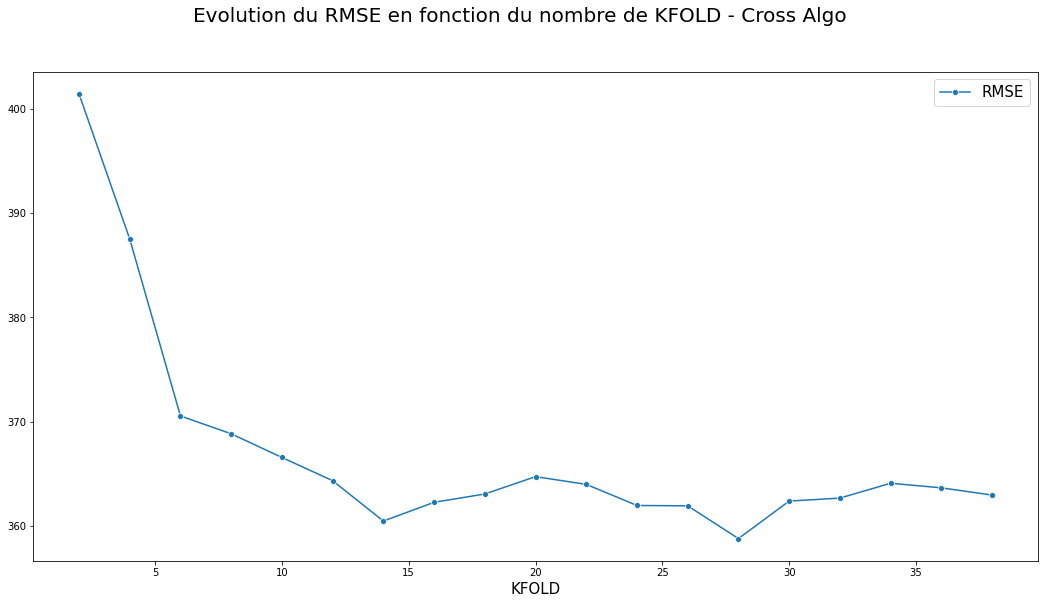

In [73]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Evolution du RMSE en fonction du nombre de KFOLD - Cross Algo", fontsize=20)

sns.lineplot(
    x = cv_list, 
    y=RMSE_list,
    label="RMSE",
    linestyle="-",
    marker = "o"
    
)

ax.set_xlabel("KFOLD", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.legend(fontsize=15)

## Lasso regression - Alpha Study

### Best alpha

In [128]:
def lasso_alpha_test(alphaList):
    lasso = Lasso(max_iter=10000)

    param_grid = [{'alpha': alphaList}]

    grid_search_lasso = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search_lasso.fit(X_train, y_train)

    grid_results_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
    
    print("--------------- LASSO ALPHA STUDY -------------------")
    print("*****************************************************")
    print("")
    print(f"The Best Alpha is --> {grid_search_lasso.best_estimator_}")
    print("-----------------------------------------------------")
    
    return grid_results_lasso, grid_search_lasso.best_estimator_

In [129]:
grid_results_lasso, bestAlpha = lasso_alpha_test([10,1000,100])

--------------- LASSO ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Lasso(alpha=100, max_iter=10000)
-----------------------------------------------------


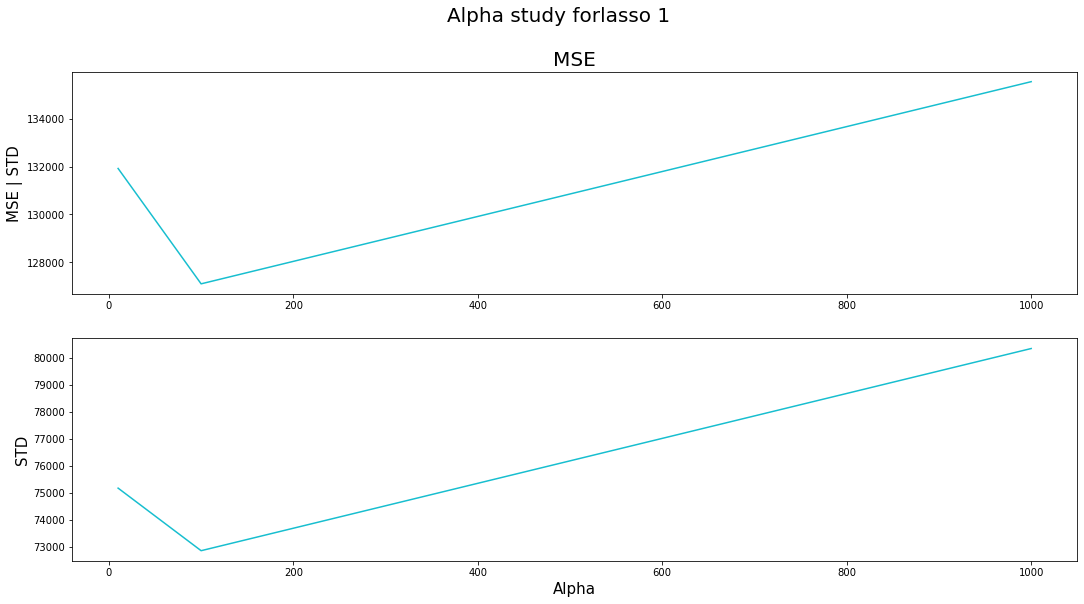

In [130]:
plot_result_alpha(grid_results_lasso, "lasso 1")

--------------- LASSO ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Lasso(alpha=150, max_iter=10000)
-----------------------------------------------------


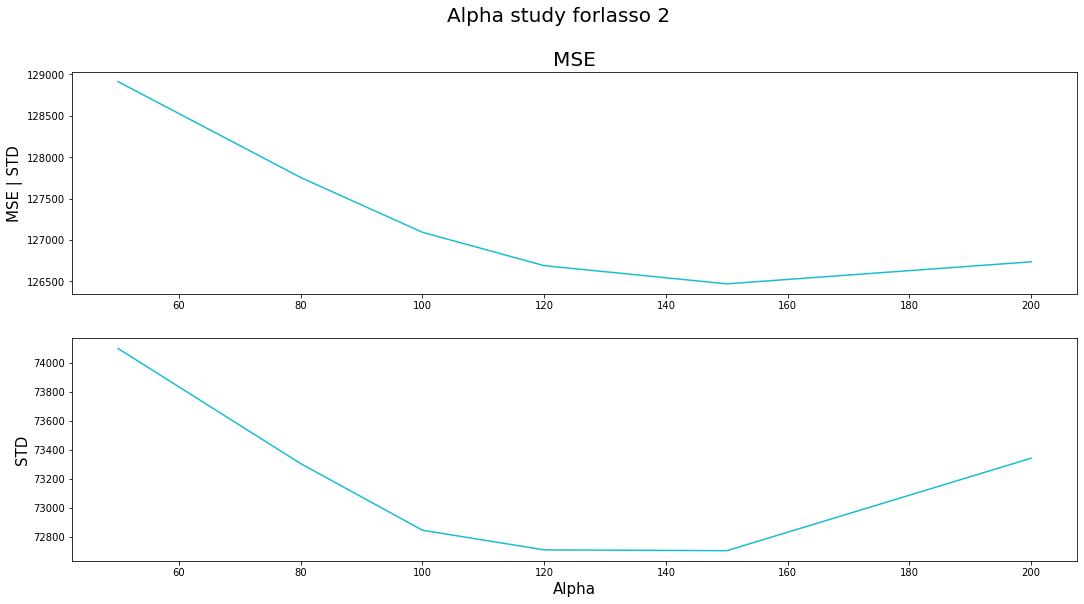

In [131]:
results, bestAlpha = lasso_alpha_test([50, 80, 100, 120, 150, 200])
plot_result_alpha(results, "lasso 2")

--------------- LASSO ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Lasso(alpha=150, max_iter=10000)
-----------------------------------------------------


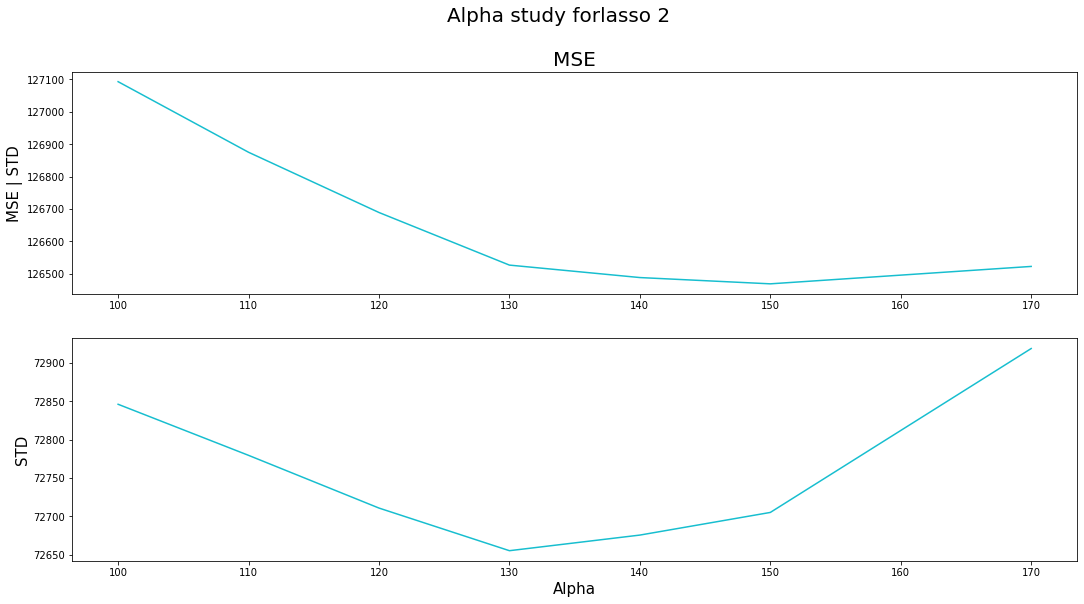

In [132]:
results, besalpha = lasso_alpha_test([100, 110, 120, 130, 140, 150, 170])
plot_result_alpha(results, "lasso 2")

## Fitting the Lasso modèle 

### Alpha = 150 (optimal)

In [133]:
lasso_150 = Lasso(alpha=150)

In [134]:
lasso_150.fit(X_train, y_train)

# predict y values for testing data set
y_pred_train = lasso_150.predict(X_train)
y_pred_test = lasso_150.predict(X_test)

print("------------------------------------------------------")
print("-------------------- LASSO_150 MODEL --------------------")
print("------------------------------------------------------")
print("")
MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)
compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

------------------------------------------------------
-------------------- LASSO_150 MODEL --------------------
------------------------------------------------------

MSE ----> 84108.5484030196
RMSE ---> 290.01473825138544
MAE ----> 229.73146654783528
MEDAE --> 197.89037003680463
R2 -----> 0.5023384146455708
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Results for TRAIN data :

MSE ----> 102143.216290497
RMSE ---> 319.59852360500196
MAE ----> 214.50834210536982
MEDAE --> 142.83435838629418
R2 -----> 0.5201406831088129
----------------------------------------------
Results for TEST data 

MSE ----> 84108.5484030196
RMSE ---> 290.01473825138544
MAE ----> 229.73146654783528
MEDAE --> 197.89037003680463
R2 -----> 0.5023384146455708
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


In [135]:
features = df_hitters.columns
beta_i = lasso_150.coef_

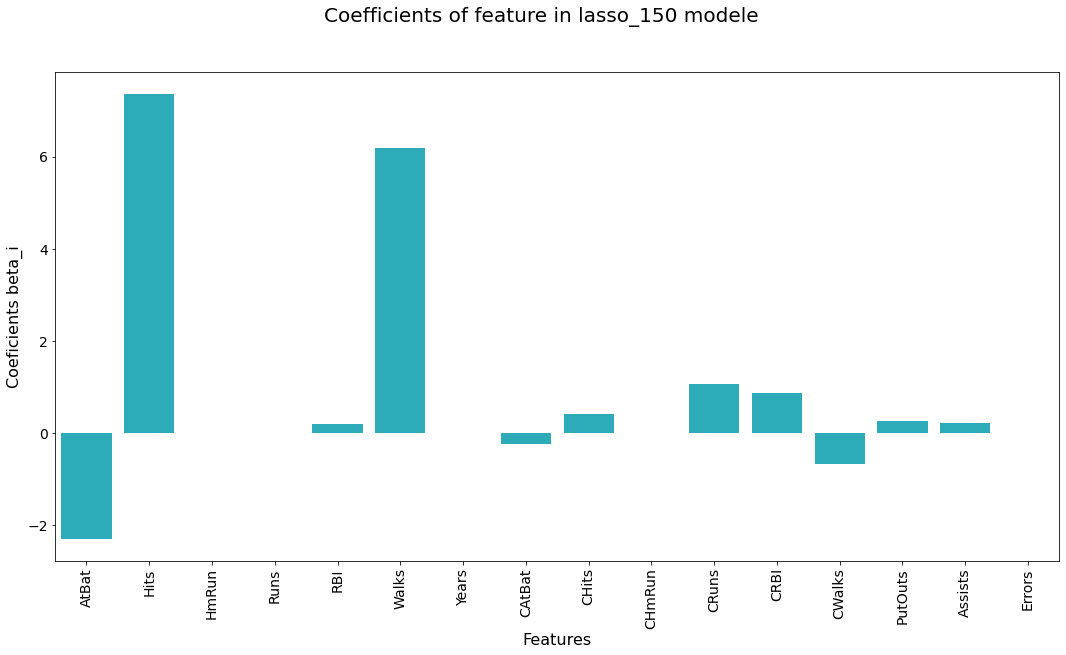

In [136]:
fig, ax = plt.subplots(figsize=(18, 9))
fig.suptitle("Coefficients of feature in lasso_150 modele", fontsize=20)

# create the bar plot using Seaborn
sns.barplot(x=features, y=beta_i, ax=ax, color=colors[0])

# customize the plot
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Coeficients beta_i', fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xticklabels(features, rotation=90, fontsize=14)

# show the plot
plt.show()

------

In [137]:
#lasso_800 = Lasso(alpha=800)
#lasso_800.fit(X_train, y_train)
#
## predict y values for testing data set
#y_pred_train = lasso_800.predict(X_train)
#y_pred_test = lasso_800.predict(X_test)
#
#print("------------------------------------------------------")
#print("-------------------- LASSO_150 MODEL --------------------")
#print("------------------------------------------------------")
#print("")
#MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)
#compare_train_test(y_train, y_pred_train, y_test, y_pred_test)
#features = df_hitters.columns
#beta_i = lasso_800.coef_
#fig, ax = plt.subplots(figsize=(18, 9))
#fig.suptitle("Coefficients of feature in lasso_800 modele", fontsize=20)
#
## create the bar plot using Seaborn
#sns.barplot(x=features, y=beta_i, ax=ax, color=colors[0])
#
## customize the plot
#ax.set_xlabel('Features', fontsize=16)
#ax.set_ylabel('Coeficients beta_i', fontsize=16)
#ax.tick_params(labelsize=14)
#ax.set_xticklabels(features, rotation=90, fontsize=14)
#
## show the plot
#plt.show()

### Visualisation des prédictions

<AxesSubplot:xlabel='Salary'>

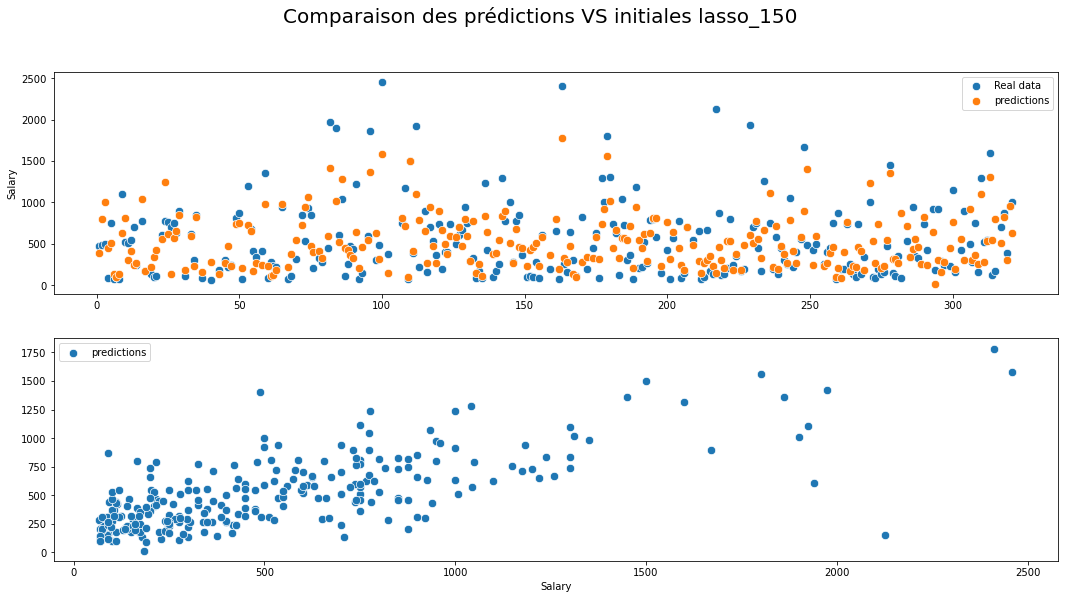

In [141]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(18,9))
fig.suptitle("Comparaison des prédictions VS initiales lasso_150", fontsize=20)

#compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

predictions = lasso_150.predict(df_hitters)

sns.scatterplot(
    ax=ax[0],
    data=df_hitters.index, 
    x=df_hitters.index, 
    #x="MSE",
    y=salary, 
    s=70,
    label="Real data"
)
sns.scatterplot(
    ax=ax[0],
    data=df_hitters, 
    x=df_hitters.index, 
    y=predictions, 
    s=70,
    label="predictions"
)

sns.scatterplot(
    ax=ax[1],
    data=df_hitters, 
    x=salary, 
    #x="MSE",
    y=predictions, 
    s=70,
    label="predictions"
)